In [1]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

  Using cached stable_baselines3-2.0.0a5-py3-none-any.whl (177 kB)
  Using cached gymnasium-0.28.1-py3-none-any.whl (925 kB)
  Using cached Shimmy-0.2.1-py3-none-any.whl (25 kB)
  Using cached rich-13.3.5-py3-none-any.whl (238 kB)
  Using cached AutoROM-0.6.1-py3-none-any.whl (9.4 kB)
  Using cached jax_jumpy-1.0.0-py3-none-any.whl (20 kB)
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
     -------------------------------------- 952.3/952.3 kB 3.0 MB/s eta 0:00:00
  Using cached Pygments-2.15.1-py3-none-any.whl (1.1 MB)
  Using cached markdown_it_py-2.2.0-py3-none-any.whl (84 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.11.2
    Uninstalling Pygments-2.11.2:
      Successfully uninstalled Pygments-2.11.2
  Attempting uninstall: gymnasium
    Found existing installation: Gymnasium 0.26.3
    Uninstalling Gymnasium-0.26.3:
      Successfully uninstalled Gymnasium-0.26.3
  Attemp

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.2.2 requires pyqt5<5.13, which is not installed.
spyder 5.2.2 requires pyqtwebengine<5.13, which is not installed.
cleanrl 1.1.0 requires gym==0.23.1, but you have gym 0.19.0 which is incompatible.
cleanrl 1.1.0 requires gymnasium<0.27.0,>=0.26.3, but you have gymnasium 0.28.1 which is incompatible.
cleanrl 1.1.0 requires stable-baselines3==1.2.0, but you have stable-baselines3 2.0.0a5 which is incompatible.


In [1]:
import gymnasium as gym

env = gym.make("CartPole-v1")

# Box(4,) means that it is a Vector with 4 components
print("Observation space:", env.observation_space)
print("Shape:", env.observation_space.shape)
# Discrete(2) means that there is two discrete actions
print("Action space:", env.action_space)

# The reset method is called at the beginning of an episode
obs, info = env.reset()
# Sample a random action
action = env.action_space.sample()
print("Sampled action:", action)
obs, reward, terminated, truncated, info = env.step(action)
# Note the obs is a numpy array
# info is an empty dict for now but can contain any debugging info
# reward is a scalar
print(obs.shape, reward, terminated, truncated, info)

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Shape: (4,)
Action space: Discrete(2)
Sampled action: 0
(4,) 1.0 False False {}


In [3]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env


class Dyn(gym.Env):
    metadata = {"render_modes": ["console"]}
    # Define constants for clearer code
    LEFT = 0
    STRAIGHT = 1
    RIGHT = 2

    def __init__(self, grid_size=120, start=(0, 50), target=(120, 50), obstacle_center=(60, 50), obstacle_radius=15, render_mode="console"):
        super(Dyn, self).__init__()
        
        # Size of the 2D-grid
        self.grid_size = grid_size

        # Initialize the agent at the start position
        self.agent_pos = np.array(start)

        # Define action and observation space
        n_actions = 3
        self.action_space = spaces.Discrete(n_actions)
        
        # The observation will be the coordinates of the agent
        # this can be described by Box space
        self.observation_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([self.grid_size, self.grid_size]), shape=(2,), dtype=np.float32
        )
        
        # Define start and target positions
        self.start = np.array(start)
        self.target = np.array(target)
        
        # Define circular obstacle
        self.obstacle_center = np.array(obstacle_center)
        self.obstacle_radius = obstacle_radius
        
        self.reward = 0
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        # Initialize the agent at the right of the grid
        self.reward = 0
        self.agent_pos = self.start
        # here we convert to float32 to make it more general (in case we want to use continuous actions)
        return np.squeeze(np.array([self.agent_pos]).astype(np.float32)), {} # empty info dict

    
    def step(self, action):
        R = 1 # minimum turning radius
        phi = np.radians(45) # maximum turning angle
        if action == self.LEFT:
            # Turn left
            L = np.tan(phi / 2) # arc length for a 45-degree turn
            c1 = self.agent_pos + np.dot(np.array([[0, -1], [1, 0]]), np.array([R, 0])) # circle center for first turn
            theta1 = np.arctan2(self.agent_pos[1] - c1[1], self.agent_pos[0] - c1[0]) # angle of first tangent
            self.agent_pos = c1 + np.dot(np.array([[np.cos(theta1 + phi), -np.sin(theta1 + phi)], [np.sin(theta1 + phi), np.cos(theta1 + phi)]]), np.array([L, 0])) # position after first turn
            c2 = self.agent_pos + np.dot(np.array([[-1, 0], [0, -1]]), np.array([R, 0])) # circle center for second turn
            theta2 = np.arctan2(c1[1] - c2[1], c1[0] - c2[0]) # angle of second tangent
            self.agent_pos = c2 + np.dot(np.array([[np.cos(theta2 - phi), -np.sin(theta2 - phi)], [np.sin(theta2 - phi), np.cos(theta2 - phi)]]), np.array([L, 0])) # position after second turn
        elif action == self.STRAIGHT:
            # Move straight
            self.agent_pos = self.agent_pos + np.array([1, 0])
        elif action == self.RIGHT:
            # Turn right
            L = np.tan(phi / 2) # arc length for a 45-degree turn
            c1 = self.agent_pos + np.dot(np.array([[0, 1], [-1, 0]]), np.array([R, 0])) # circle center for first turn
            theta1 = np.arctan2(c1[1] - self.agent_pos[1], c1[0] - self.agent_pos[0]) # angle of first tangent
            self.agent_pos = c1 + np.dot(np.array([[np.cos(theta1 - phi), -np.sin(theta1 - phi)], [np.sin(theta1 - phi), np.cos(theta1 - phi)]]), np.array([L, 0])) # position after first turn
            c2 = self.agent_pos + np.dot(np.array([[1, 0], [0, -1]]), np.array([R, 0])) # circle center for second turn
            theta2 = np.arctan2(c2[1] - c1[1], c2[0] - c1[0]) # angle of second tangent
            self.agent_pos = c2 + np.dot(np.array([[np.cos(theta2 + phi), -np.sin(theta2 + phi)], [np.sin(theta2 + phi), np.cos(theta2 + phi)]]), np.array([L, 0])) # position after second turn
        else:
            raise ValueError(
                f"Received invalid action={action} which is not part of the action space"
            )

        # Account for the boundaries of the grid
        self.agent_pos = np.clip(self.agent_pos, [0, 0], [self.grid_size, self.grid_size])

        # Check if the agent is inside the obstacle
        inside_obstacle = np.linalg.norm(self.agent_pos - self.obstacle_center) <= self.obstacle_radius
        
        # Check if the agent has reached the target
        at_target = np.linalg.norm(self.agent_pos - self.target) < 0.5


        if inside_obstacle:
            self.reward = -1000  # Higher penalty for colliding with obstacles
            done = False
        elif at_target:
            self.reward = 10000  # Higher reward for reaching the target
            done = True
        else:
            distance_to_target = np.linalg.norm(self.agent_pos - self.target)
            self.reward = -distance_to_target  # Penalize based on the distance to the target
            done = False

        truncated = False  # we do not limit the number of steps here
        # Return the new observation, reward, done, and any additional information as a dictionary
        return np.squeeze(np.array([self.agent_pos]).astype(np.float32)), self.reward, done,truncated, {}
    
    def render(self):
        # agent is represented as a cross, rest as a dot
        if self.render_mode == "console":
            print("." * self.agent_pos, end="")
            print("x", end="")
            print("." * (self.grid_size - self.agent_pos))
    
env = Dyn()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

In [10]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Instantiate the env
vec_env = make_vec_env(Dyn, n_envs=1, env_kwargs=dict(grid_size=120))

In [12]:
# Train the agent
model = PPO("MlpPolicy",
            env, 
            verbose=1,
            learning_rate=1e-4,
            n_steps=2048, 
            batch_size=128, 
            n_epochs=20, 
            gamma=0.999, 
            gae_lambda=0.98,
            device='cuda').learn(3e5)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 912  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 660           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 4.6419213e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | -6.44e-05     |
|    learning_rate        | 0.0001        |
|    loss                 | 2.78e+06      |
|    n_updates            | 20            |
|    policy_gradient_loss | -0.00014

------------------------------------------
| time/                   |              |
|    fps                  | 474          |
|    iterations           | 13           |
|    time_elapsed         | 56           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0014898423 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.07        |
|    explained_variance   | 1.79e-07     |
|    learning_rate        | 0.0001       |
|    loss                 | 2.34e+06     |
|    n_updates            | 240          |
|    policy_gradient_loss | -0.00155     |
|    value_loss           | 4.65e+06     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 474           |
|    iterations           | 14            |
|    time_elapsed         | 60            |
|    t

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 3.89e+03      |
|    ep_rew_mean          | -1.95e+05     |
| time/                   |               |
|    fps                  | 478           |
|    iterations           | 23            |
|    time_elapsed         | 98            |
|    total_timesteps      | 47104         |
| train/                  |               |
|    approx_kl            | 2.9762392e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.06         |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0001        |
|    loss                 | 3.33e+07      |
|    n_updates            | 440           |
|    policy_gradient_loss | -0.000211     |
|    value_loss           | 6.31e+07      |
-------------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.56e+03     |
|    ep_rew_mean          | -8.54e+04    |
| time/                   |              |
|    fps                  | 474          |
|    iterations           | 32           |
|    time_elapsed         | 138          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 4.084088e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.05        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 3.01e+07     |
|    n_updates            | 620          |
|    policy_gradient_loss | -0.000115    |
|    value_loss           | 6.78e+07     |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.21e+03     |
|    ep_rew_mean          | -6.37e+04    |
| time/                   |              |
|    fps                  | 474          |
|    iterations           | 42           |
|    time_elapsed         | 181          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0025468078 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.03        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0001       |
|    loss                 | 7.84e+06     |
|    n_updates            | 820          |
|    policy_gradient_loss | -0.00119     |
|    value_loss           | 1.71e+07     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 558           |
|    ep_rew_mean          | -2.7e+04      |
| time/                   |               |
|    fps                  | 475           |
|    iterations           | 51            |
|    time_elapsed         | 219           |
|    total_timesteps      | 104448        |
| train/                  |               |
|    approx_kl            | 0.00033471582 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.02         |
|    explained_variance   | 0.00112       |
|    learning_rate        | 0.0001        |
|    loss                 | 3.72e+06      |
|    n_updates            | 1000          |
|    policy_gradient_loss | -0.000553     |
|    value_loss           | 7.29e+06      |
-------------------------------------------
-------------------------------------------
| rollout/                |     

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 391           |
|    ep_rew_mean          | -1.19e+04     |
| time/                   |               |
|    fps                  | 474           |
|    iterations           | 60            |
|    time_elapsed         | 258           |
|    total_timesteps      | 122880        |
| train/                  |               |
|    approx_kl            | 2.0002568e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.03         |
|    explained_variance   | 0.00112       |
|    learning_rate        | 0.0001        |
|    loss                 | 7.05e+06      |
|    n_updates            | 1180          |
|    policy_gradient_loss | -0.000159     |
|    value_loss           | 1.5e+07       |
-------------------------------------------
-------------------------------------------
| rollout/                |     

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 343           |
|    ep_rew_mean          | -8.18e+03     |
| time/                   |               |
|    fps                  | 471           |
|    iterations           | 69            |
|    time_elapsed         | 299           |
|    total_timesteps      | 141312        |
| train/                  |               |
|    approx_kl            | 5.8974285e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.03         |
|    explained_variance   | 0.00107       |
|    learning_rate        | 0.0001        |
|    loss                 | 1.64e+07      |
|    n_updates            | 1360          |
|    policy_gradient_loss | -0.000349     |
|    value_loss           | 3.04e+07      |
-------------------------------------------
------------------------------------------
| rollout/                |      

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 333           |
|    ep_rew_mean          | -7.93e+03     |
| time/                   |               |
|    fps                  | 469           |
|    iterations           | 78            |
|    time_elapsed         | 340           |
|    total_timesteps      | 159744        |
| train/                  |               |
|    approx_kl            | 0.00038503067 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.01         |
|    explained_variance   | 0.00217       |
|    learning_rate        | 0.0001        |
|    loss                 | 4.55e+06      |
|    n_updates            | 1540          |
|    policy_gradient_loss | -0.000363     |
|    value_loss           | 1.01e+07      |
-------------------------------------------
------------------------------------------
| rollout/                |      

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 319           |
|    ep_rew_mean          | -6.35e+03     |
| time/                   |               |
|    fps                  | 470           |
|    iterations           | 88            |
|    time_elapsed         | 383           |
|    total_timesteps      | 180224        |
| train/                  |               |
|    approx_kl            | 0.00044367512 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.02         |
|    explained_variance   | 0.00235       |
|    learning_rate        | 0.0001        |
|    loss                 | 5.84e+06      |
|    n_updates            | 1740          |
|    policy_gradient_loss | -0.000388     |
|    value_loss           | 1.26e+07      |
-------------------------------------------
------------------------------------------
| rollout/                |      

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 303          |
|    ep_rew_mean          | -6.41e+03    |
| time/                   |              |
|    fps                  | 476          |
|    iterations           | 98           |
|    time_elapsed         | 421          |
|    total_timesteps      | 200704       |
| train/                  |              |
|    approx_kl            | 0.0016282796 |
|    clip_fraction        | 0.000806     |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.01        |
|    explained_variance   | 0.00141      |
|    learning_rate        | 0.0001       |
|    loss                 | 1.77e+07     |
|    n_updates            | 1940         |
|    policy_gradient_loss | -0.00145     |
|    value_loss           | 2.74e+07     |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 285          |
|    ep_rew_mean          | -4.18e+03    |
| time/                   |              |
|    fps                  | 479          |
|    iterations           | 108          |
|    time_elapsed         | 460          |
|    total_timesteps      | 221184       |
| train/                  |              |
|    approx_kl            | 0.0021190303 |
|    clip_fraction        | 2.44e-05     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.974       |
|    explained_variance   | 0.00299      |
|    learning_rate        | 0.0001       |
|    loss                 | 4.74e+06     |
|    n_updates            | 2140         |
|    policy_gradient_loss | -0.00171     |
|    value_loss           | 1.09e+07     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 271          |
|    ep_rew_mean          | -3.26e+03    |
| time/                   |              |
|    fps                  | 483          |
|    iterations           | 118          |
|    time_elapsed         | 499          |
|    total_timesteps      | 241664       |
| train/                  |              |
|    approx_kl            | 9.593577e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.972       |
|    explained_variance   | 0.00316      |
|    learning_rate        | 0.0001       |
|    loss                 | 8.8e+06      |
|    n_updates            | 2340         |
|    policy_gradient_loss | -0.000144    |
|    value_loss           | 1.21e+07     |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 274          |
|    ep_rew_mean          | -2.79e+03    |
| time/                   |              |
|    fps                  | 487          |
|    iterations           | 128          |
|    time_elapsed         | 537          |
|    total_timesteps      | 262144       |
| train/                  |              |
|    approx_kl            | 0.0028693704 |
|    clip_fraction        | 0.011        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1           |
|    explained_variance   | 0.00409      |
|    learning_rate        | 0.0001       |
|    loss                 | 2.5e+06      |
|    n_updates            | 2540         |
|    policy_gradient_loss | -0.00209     |
|    value_loss           | 5.09e+06     |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 283         |
|    ep_rew_mean          | -2.29e+03   |
| time/                   |             |
|    fps                  | 489         |
|    iterations           | 138         |
|    time_elapsed         | 576         |
|    total_timesteps      | 282624      |
| train/                  |             |
|    approx_kl            | 0.001050517 |
|    clip_fraction        | 0.00156     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.986      |
|    explained_variance   | 0.00467     |
|    learning_rate        | 0.0001      |
|    loss                 | 5.49e+06    |
|    n_updates            | 2740        |
|    policy_gradient_loss | -0.00104    |
|    value_loss           | 1.22e+07    |
-----------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 28

In [15]:
# Test the trained agent
# using the vecenv
obs = vec_env.reset()
n_steps = 155
rewards = []

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print(f"Step {step + 1}")
    print("Action: ", action)
    obs, reward, done, info = vec_env.step(action)
    rewards.append(reward)
    print("obs=", obs, "reward=", reward, "done=", done)
    vec_env.render()
    if done:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print("Goal reached!", "reward=", reward)
        break

Step 1
Action:  [2]
obs= [[ 1.0897902 48.86562  ]] reward= [-118.91562] done= [False]
Step 2
Action:  [2]
obs= [[ 2.1795805 47.73124  ]] reward= [-117.84226] done= [False]
Step 3
Action:  [2]
obs= [[ 3.2693706 46.59686  ]] reward= [-116.78023] done= [False]
Step 4
Action:  [2]
obs= [[ 4.359161 45.46248 ]] reward= [-115.72983] done= [False]
Step 5
Action:  [2]
obs= [[ 5.4489512 44.3281   ]] reward= [-114.69138] done= [False]
Step 6
Action:  [2]
obs= [[ 6.538741 43.193718]] reward= [-113.66522] done= [False]
Step 7
Action:  [2]
obs= [[ 7.6285315 42.059338 ]] reward= [-112.65168] done= [False]
Step 8
Action:  [2]
obs= [[ 8.718322 40.924957]] reward= [-111.6511] done= [False]
Step 9
Action:  [2]
obs= [[ 9.808112 39.790577]] reward= [-110.66383] done= [False]
Step 10
Action:  [2]
obs= [[10.8979025 38.656193 ]] reward= [-109.69025] done= [False]
Step 11
Action:  [2]
obs= [[11.987692 37.521812]] reward= [-108.73069] done= [False]
Step 12
Action:  [2]
obs= [[13.077482 36.387432]] reward= [-107

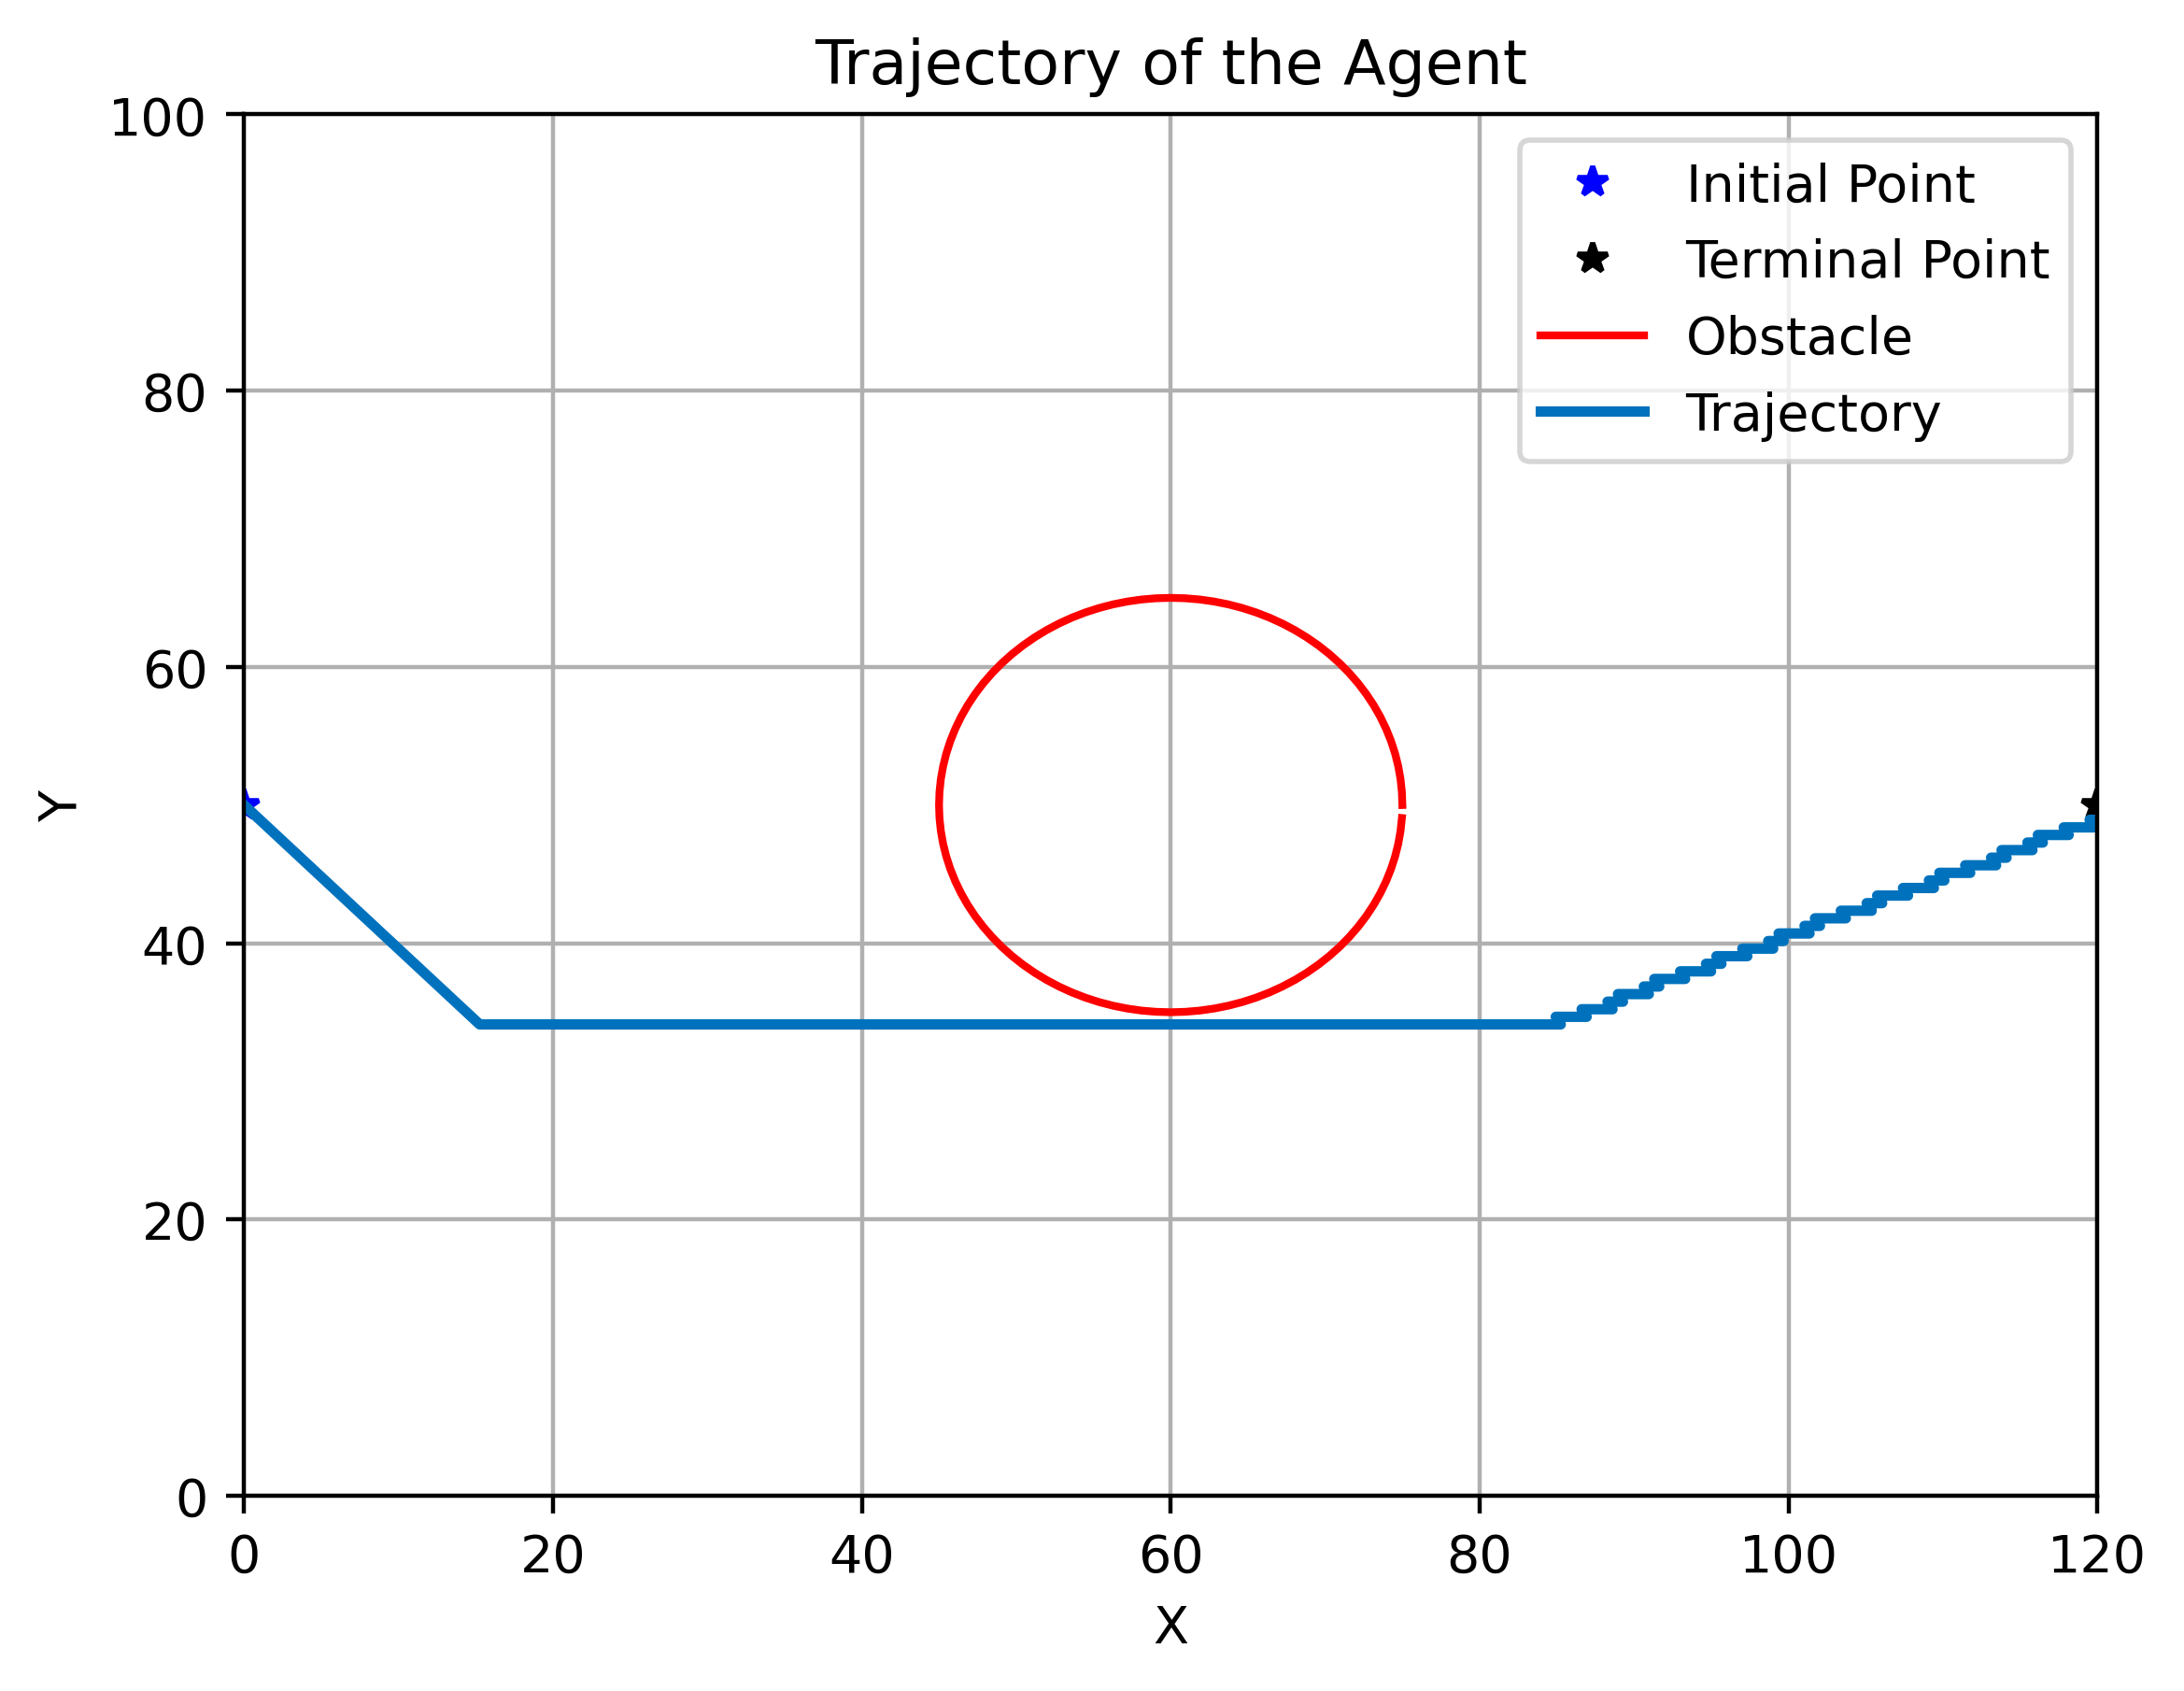

In [16]:
import matplotlib.pyplot as plt

# Test the trained agent
obs = vec_env.reset()
n_steps = 155
rewards = []
xSol = [obs[0][0]]  # List to store x-coordinate of agent's trajectory
ySol = [obs[0][1]]  # List to store y-coordinate of agent's trajectory

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    rewards.append(reward)
    xSol.append(obs[0][0])  # Append current x-coordinate to trajectory list
    ySol.append(obs[0][1])  # Append current y-coordinate to trajectory list
    if done:
        print("Goal reached!", "reward=", reward)
        break

# Plot the trajectory
x_initial = 0
y_initial = 50
x_final = 120
y_final = 50
th = np.arange(0, 2*np.pi, np.pi/50)
r2 = 15
x2 = 60
y2 = 50
obstacle_2_x = r2 * np.cos(th) + x2
obstacle_2_y = r2 * np.sin(th) + y2

plt.figure(dpi=400)
plt.plot(x_initial, y_initial, '*b')  # Initial point
plt.plot(x_final, y_final, '*k')  # Terminal point
plt.plot(obstacle_2_x, obstacle_2_y, 'r')  # Obstacle
plt.plot(xSol, ySol, color=[0, 0.4470, 0.7410], linewidth=2)
plt.axis([0, 120, 0, 100])
plt.title('Trajectory of the Agent')
plt.legend(['Initial Point', 'Terminal Point', 'Obstacle', 'Trajectory'])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.savefig('rlPlot.png', dpi=1200)
plt.show()